### File Description

This file is responsible for presenting the graphs and thus verifying and analyzing the results of the trained models. The main function of this file is to provide a clear visualization of the models' performance in terms of forecasting and accuracy. 

This file facilitates the analysis of results, making it easier to interpret and compare the trained models.


### Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.dates as mdates
import ast

### Analyzing raw data

In [6]:
df_raw_data = pd.read_csv("database/combined_data.csv", sep=';')

In [7]:
filtered_products = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel', 'querosenedeaviacao']
df_filtered = df_raw_data[(df_raw_data['product'].isin(filtered_products))]

In [8]:
statistics = df_filtered.groupby('product')['m3'].agg(
    min='min', 
    max='max', 
    mean='mean', 
    std='std'
)

print(statistics)

                           min           max           mean            std
product                                                                   
etanolhidratado       0.000000  1.077622e+06   34304.618694  101520.798647
gasolinac             5.000000  1.035389e+06   87858.227567  134453.059672
glp                 356.226449  3.369416e+05   37292.707901   52741.761740
oleodiesel          478.400000  1.312177e+06  135535.235972  183412.660135
querosenedeaviacao    0.000000  3.711453e+05   15847.039397   39806.093694


In [9]:
filtered_products = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel', 'querosenedeaviacao']
df_sp = df_raw_data[(df_raw_data['state'] == 'sp') & (df_raw_data['product'].isin(filtered_products))]

In [10]:
substituicoes = {
    'etanolhidratado': 'Etanol Hidratado',
    'gasolinac': 'Gasolina Comum',
    'glp': 'GLP',
    'oleodiesel': 'Óleo Diesel',
    'querosenedeaviacao': 'Querosene de Aviação'
}

df_sp['product'] = df_sp['product'].replace(substituicoes)

/tmp/ipykernel_2064761/3857495774.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp['product'] = df_sp['product'].replace(substituicoes)


datetime64[ns]


/tmp/ipykernel_2064761/4115257494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp['timestamp'] = pd.to_datetime(df_sp['timestamp'], errors='coerce')


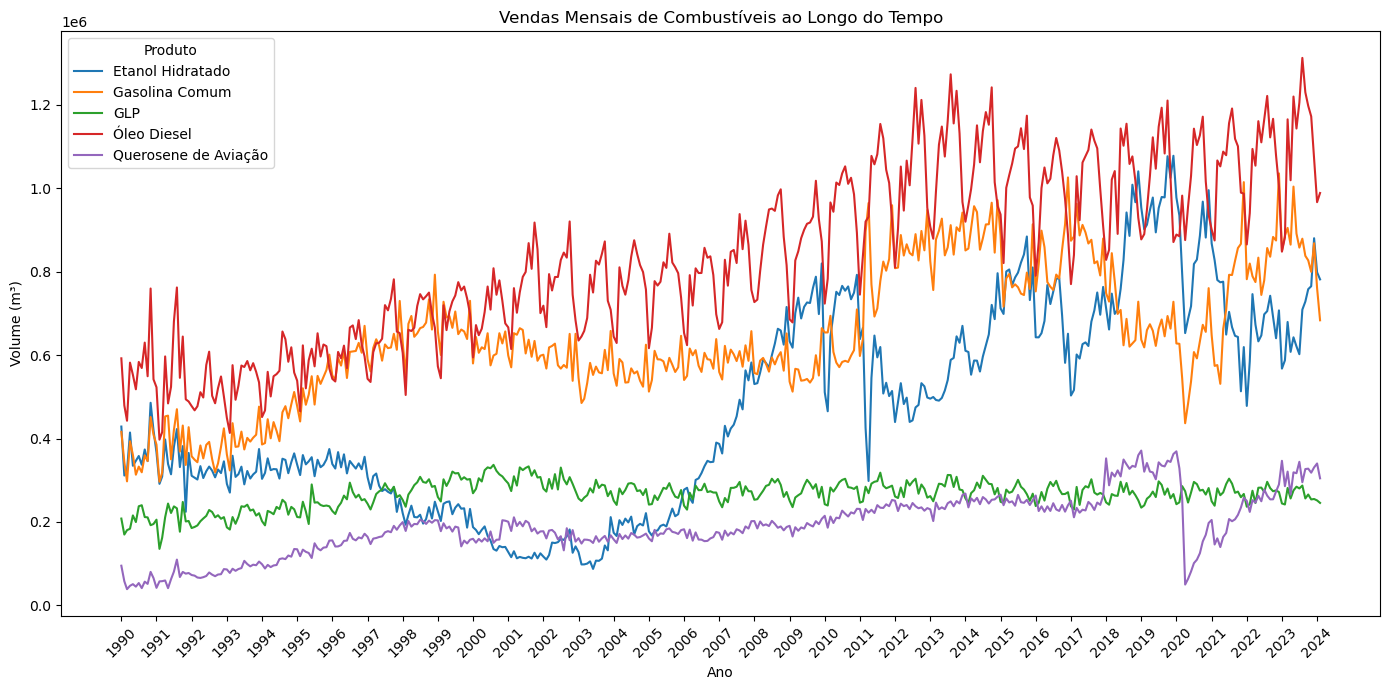

In [11]:
df_sp['timestamp'] = pd.to_datetime(df_sp['timestamp'], errors='coerce') 

print(df_sp['timestamp'].dtypes)

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_sp, x='timestamp', y='m3', hue='product')

plt.title('Vendas Mensais de Combustíveis ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Volume (m³)')

unique_years = df_sp['timestamp'].dt.year.dropna().unique() 
plt.xticks(ticks=[pd.Timestamp(f'{year}-01-01') for year in unique_years], labels=unique_years, rotation=45)

plt.legend(title='Produto')
plt.tight_layout() 
plt.show()

In [12]:
# # Converter timestamp para datetime
# df_sp['timestamp'] = pd.to_datetime(df_sp['timestamp'], errors='coerce')

# # Filtrar apenas Gasolina Comum
# df_gasolina = df_sp[df_sp['product'] == 'Etanol Hidratado']

# # Criar a figura e plotar a linha preta
# plt.figure(figsize=(14, 7))
# sns.lineplot(data=df_gasolina, x='timestamp', y='m3', color='black')

# # Remover eixos X e Y
# plt.xticks([])
# plt.yticks([])
# plt.xlabel('')
# plt.ylabel('')
# plt.box(False)

# # Salvar como PNG sem fundo
# plt.savefig('output_path.png', transparent=True, dpi=300, bbox_inches='tight')

# # Exibir gráfico
# plt.show()

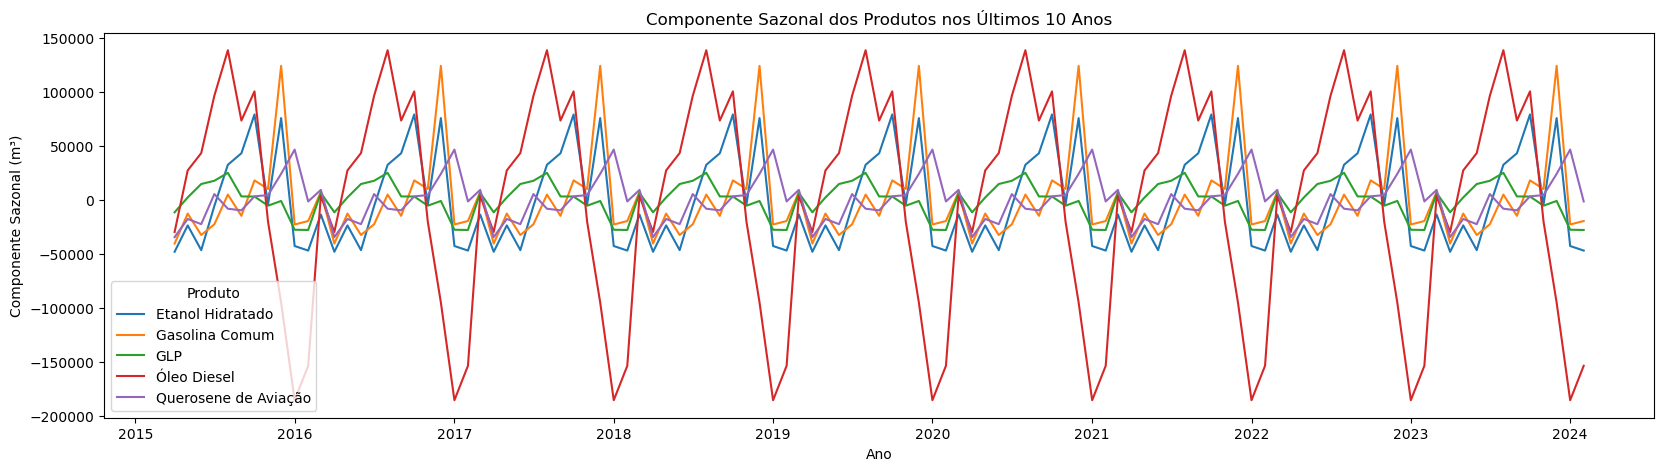

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_filtered = df_sp[df_sp['timestamp'] >= pd.Timestamp.now() - pd.DateOffset(years=10)]

def decompose_and_plot(product_data):
    result = seasonal_decompose(product_data['m3'], model='additive', period=12)
    seasonal = result.seasonal
    return seasonal

seasonal_components = pd.DataFrame()

for product in df_filtered['product'].unique():
    product_data = df_filtered[df_filtered['product'] == product].set_index('timestamp')
    seasonal = decompose_and_plot(product_data)
    seasonal_components[product] = seasonal

seasonal_components.reset_index(inplace=True)
seasonal_components.rename(columns={'index': 'timestamp'}, inplace=True)

plt.figure(figsize=(20, 5))
sns.lineplot(data=seasonal_components.melt(id_vars='timestamp', var_name='product', value_name='seasonal'),
             x='timestamp', y='seasonal', hue='product')
plt.title('Componente Sazonal dos Produtos nos Últimos 10 Anos')
plt.xlabel('Ano')
plt.ylabel('Componente Sazonal (m³)')
plt.legend(title='Produto')
plt.show()

### Loading data

In [14]:
# # INFO: LAST YEAR

df_lstm = pd.read_excel("LSTM/results_model_local/lstm_results_pytorch.xlsx") 
df_beats = pd.read_excel("N-BEATS/results_model_local/nbeats_results.xlsx")

# Combinar os DataFrames
df = pd.concat([df_lstm, df_beats], ignore_index=True)

# INFO: 5 YEARS

In [15]:
df = df[~df['PRODUCT'].isin(['gasolinadeaviacao', 'oleocombustivel', 'queroseneiluminante'])]

In [16]:
derivados = {
    'etanolhidratado': 'Etanol Hidratado',
    'gasolinac': 'Gasolina Comum',
    'glp': 'GLP',
    'oleodiesel': 'Óleo Diesel',
    'querosenedeaviacao': 'Querosene de Aviação'
}

df['PRODUCT'] = df['PRODUCT'].replace(derivados)

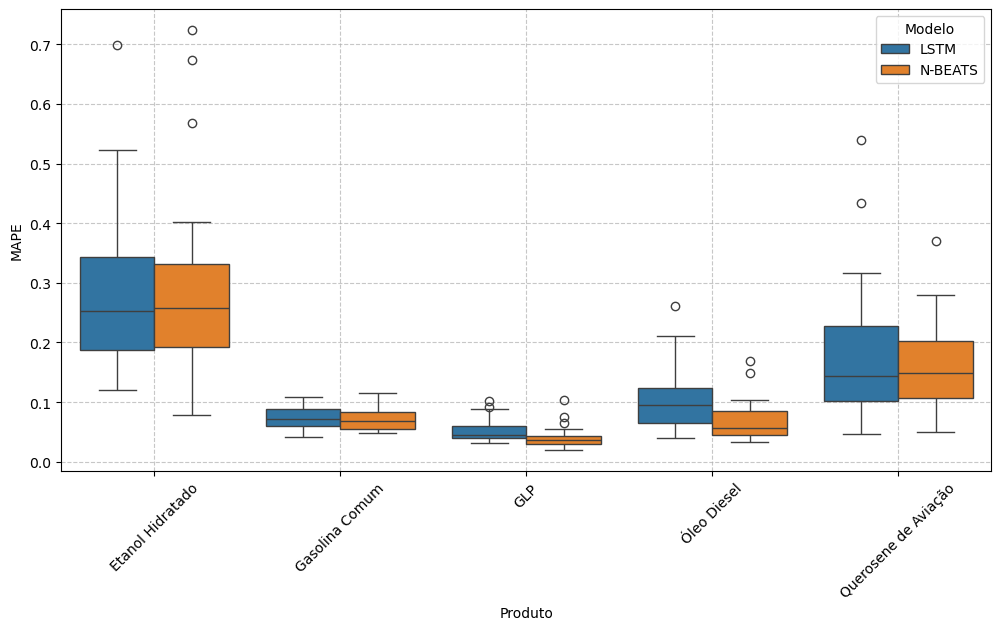

In [17]:
# Criar o box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="PRODUCT", y="MAPE", hue="MODEL", data=df)
plt.xlabel("Produto")
plt.ylabel("MAPE")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()